# High Level Features: LHC Olympics 2020 anomaly detection dataset

In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../scripts/')
from variables import *

## Load data
High level features ae used for this study.    
High level features: variables which are computed using other vriables. These variables are defined based on physics motivation.

In [2]:
def load_data(input_frame):
    '''
    Input: initial data-frame 
    Return: another data-frame with some extra variables
    '''
    
    #copy the input_dataframe
    output_frame = input_frame.copy()

    #Add more variables computed using the initial variables
    for jet in ["j1", "j2"]:
        output_frame["pt" + jet] = np.sqrt(input_frame["px" + jet]**2 + input_frame["py" + jet]**2)
        output_frame["eta" + jet] = np.arcsinh(input_frame["pz" + jet] / output_frame["pt" + jet])
        output_frame["phi" + jet] = np.arctan2(input_frame["py" + jet], input_frame["px" + jet])
        output_frame["m" + jet] = input_frame["m" + jet]
        output_frame["p" + jet] = np.sqrt(input_frame["pz" + jet]**2 + output_frame["pt" + jet]**2)
        output_frame["e" + jet] = np.sqrt(output_frame["m" + jet]**2 + output_frame["p" + jet]**2)
        output_frame["tau21" + jet] = input_frame["tau2" + jet] / input_frame["tau1" + jet]
        output_frame["tau32" + jet] = input_frame["tau3" + jet] / input_frame["tau2" + jet]
    
    #Kinematic variables of the di-jet system
    output_frame["pxjj"] = output_frame["pxj1"] + output_frame["pxj2"]
    output_frame["pyjj"] = output_frame["pyj1"] + output_frame["pyj2"]
    output_frame["pzjj"] = output_frame["pzj1"] + output_frame["pzj2"]
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt(output_frame["pxjj"]**2 + output_frame["pyjj"]**2 + output_frame["pzjj"]**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    # NaN will appear while dividing by zero tau1 and tau1 variables. The NaNs are removed.
    output_frame.dropna(inplace = True)
    output_frame.reset_index(drop = True, inplace = True)

    
    return output_frame
        

### Raw dataset
The dataset is available here: https://zenodo.org/record/4536377#.YHTfCBNKhTZ   

* It consists of 1M QCD dijet events and 100k W'->XY events, with X->qq and Y->qq. The events are randomly shuffled together.
* A signal/background truth bit for each event is provided to identify the signal and background events.
* The W', X, and Y masses are 3.5 TeV, 500 GeV and 100 GeV respectively.

In [3]:
# Raw input data where background and signal are randomly mixed
raw_input = pd.read_hdf("../data/events_anomalydetection_v2.features.h5")

## Define the data frames

In [4]:
rawdata_shape = raw_input.shape
rawdata_features = list(raw_input.columns)
print("Shape of the raw dataframe: ", rawdata_shape)
print ("Features in the raw dataframe: ", rawdata_features)

Shape of the raw dataframe:  (1100000, 15)
Features in the raw dataframe:  ['pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2', 'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 'label']


In [5]:
# open the raw input file
df_sig_bkg = load_data(raw_input)

#signal and background events can be identified using the `label` feature
# Signal: label=1
# Backgrouns: label=0
df_bkg = df_sig_bkg.loc[df_sig_bkg['label'] == 0]
df_sig = df_sig_bkg.loc[df_sig_bkg['label'] == 1]

## Visualize input features

In [6]:
def plot_inputs_2d(var1, var2, df_sig, df_bkg):
    '''
    makes 2D plots of the input variables 
    '''
    nbins_var1 = var_nbins[var1]
    nbins_var2 = var_nbins[var2]
    min_var1 = var_range[var1][0]
    max_var1 = var_range[var1][1]
    min_var2 = var_range[var2][0]
    max_var2 = var_range[var2][1]
    
    fig = plt.figure(figsize=(12,4))
    fig.subplots_adjust(hspace=0.6, wspace=0.4)
    

    ax = fig.add_subplot(1, 2, 1)
    #plt.text(0.5, 0.5, str((2, 4, i)), fontsize=18, ha='center')
    plt.title("Signal")
    plt.hist2d(df_sig[var1], df_sig[var2], bins = [nbins_var1, nbins_var2], range = [[min_var1, max_var1], [min_var2, max_var2]], cmap = 'inferno')
    plt.ylabel(var_axis_label[var2])
    plt.xlabel(var_axis_label[var1])
    ax = fig.add_subplot(1, 2, 2)
    plt.title("Background")
    plt.hist2d(df_bkg[var1], df_bkg[var2], bins = [nbins_var1, nbins_var2], range = [[min_var1, max_var1], [min_var2, max_var2]], cmap = 'inferno')
    plt.ylabel(var_axis_label[var2])
    plt.xlabel(var_axis_label[var1])
    #plt.legend()

### Subleading jet mass as a function of leading jet mass
In the signal the jet masses are 100 GeV and 500 GeV. In the background we expect a lot of jets with lower energy.

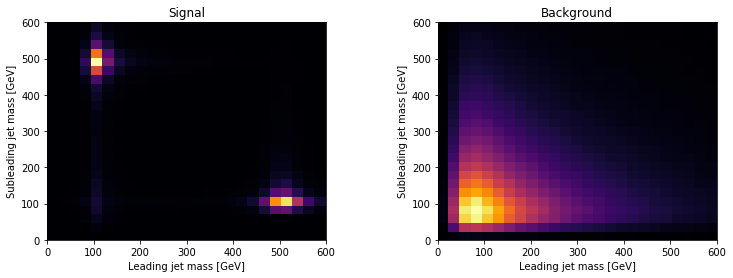

In [7]:
plot_inputs_2d('mj1', 'mj2', df_sig, df_bkg)

### Subleading jet energy as a function of leading jet energy
The values are quite dofferent for the expected signals.

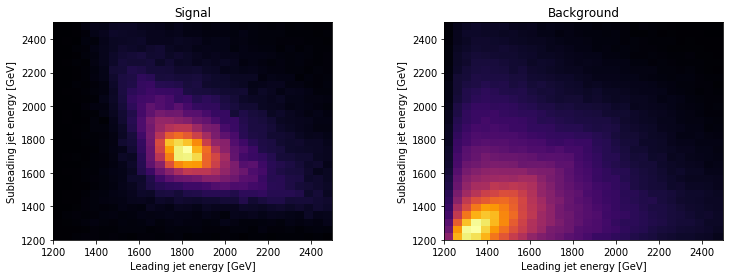

In [8]:
plot_inputs_2d('ej1', 'ej2', df_sig, df_bkg)

### Leading jet: $p_{y}$ vs $p_{x}$ (momentum in the x-direction)
In general, the momenta components are higher in the signal. 

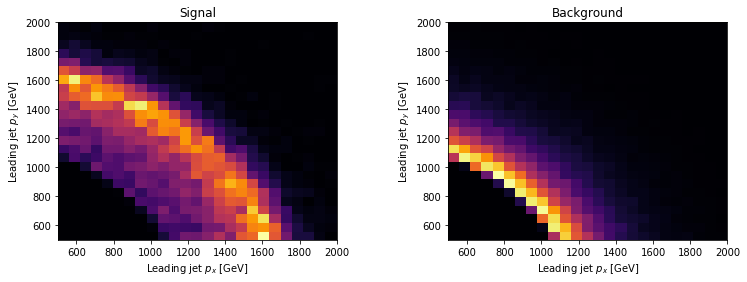

In [9]:
plot_inputs_2d('pxj1', 'pyj1', df_sig, df_bkg)

In [10]:
def plot_variables(var, title, density = False):
    nbins = var_nbins[var]
    min_var = var_range[var][0]
    max_var = var_range[var][1]
    
    plt.title(title)
    if density == False:
        plt.ylabel("Events")
    else:
        plt.ylabel("Normalized events")
    plt.xlabel(var_axis_label[var])
    plt.hist(df_sig_bkg[var], bins = nbins, range = (min_var, max_var), color = "tab:blue",  histtype = "step", label = "Signal + Background", density = density)
    plt.hist(df_bkg[var], bins = nbins, range = (min_var, max_var), color = "tab:green", alpha = 0.3, label = "Background", density = density)
    plt.hist(df_sig[var], bins = nbins, range = (min_var, max_var), color = "tab:red", histtype = "step", label = "Signal", density = density)
    plt.legend()

### Mass of the di-jet system
The background distribution follows a decreasing trend and the signal is expected to appear as a bump on the dijet mass distribution. In this example is signal mass is 3500 GeV.

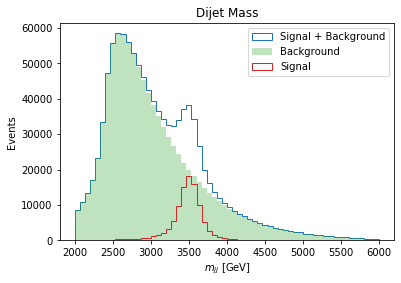

In [11]:
plot_variables("mjj", "Dijet Mass")

### Energy of the di-jet system
The same treand as the mass distribution and the signal is expected to appear as a bump

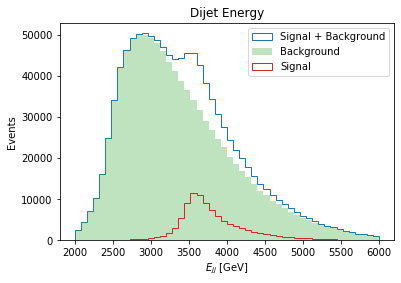

In [12]:
plot_variables("ejj", "Dijet Energy")

### Nsubjettiness ($\tau_{21}$) 
The background distribution is expected to be very different from the signal. $\tau_{21}$ is one of the most sensitive quantity since the signal jets have a 2-prong structure.

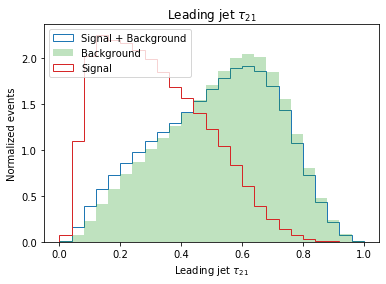

In [13]:
plot_variables("tau21j1", "Leading jet $\\tau_{21}$", True)

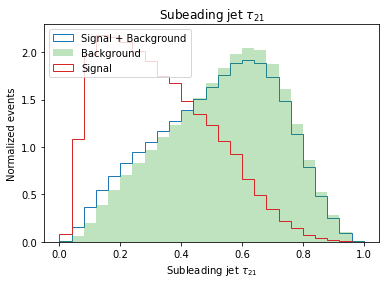

In [14]:
plot_variables("tau21j2", "Subeading jet $\\tau_{21}$", True)

### Nsubjettiness ($\tau_{31}$) 
The background distribution is expected to be very different from the 3-prong signal. In this case, the signal has a 2-prong structure, so $\tau_{32}$ is not a good discriminating quantity. 

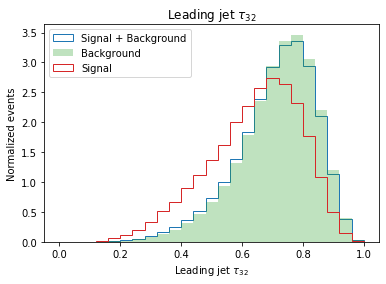

In [15]:
plot_variables("tau32j1", "Leading jet $\\tau_{32}$", True)

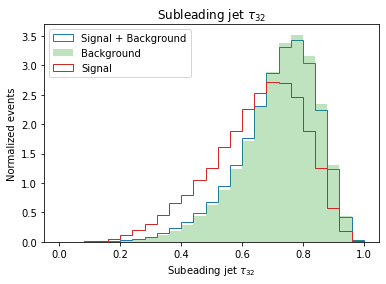

In [16]:
plot_variables("tau32j2", "Subleading jet $\\tau_{32}$", True)